In [60]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

from numpy.polynomial.polynomial import polyfit

import pyarrow as pa
import pyarrow.parquet as pq

import statsmodels.api as sm
import statsmodels
#import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelOLS



import warnings
warnings.filterwarnings("ignore")

### Preface

This notebook just explores the employment analysis part of the paper ["The Consumption Response to Trade Shocks: Evidence from the US-China Trade War."](http://www.waugheconomics.com/uploads/2/2/5/6/22563786/waugh_consumption.pdf) . This is in Section 5. It mimics many parts of the auto analysis (visualization, tabular representations, and regression analysis). Below I also report the unweighted an weighted regression results.

### Steup for analysis

Just some basic things, bring in the data, make the transformations that we want, etc...

In [61]:
fig_path = "C:\\github\\expenditure_tradeshocks\\figures"

This is the cell below to change if you want to toggle between all employment and only goods producing employment.

In [62]:
try: driver_flag
    
except NameError: driver_flag = False

In [63]:
file_path = os.getcwd()

#trade_county = pq.read_table(file_path + "\\data\\trade_employment_goods.parquet").to_pandas()

trade_county = pq.read_table(file_path + "\\data\\trade_employment_blssingle19.parquet").to_pandas()

In [64]:
trade_county["time"] = pd.to_datetime(trade_county.time)

trade_county.set_index(["area_fips", "time"],inplace = True)

In [65]:
trade_county["log_tariff"] = np.log(1+.01*trade_county["tariff"])

trade_county["log_exp_total"] = np.log(trade_county["total_exp_pc"]).replace(-np.inf, np.nan)

trade_county["log_exp_china"] = np.log(trade_county["china_exp_pc"]).replace(-np.inf, np.nan)

emp_measure = "emp_rtl"
# Here you specify the type of employment you want. emp_all is total employment. emp_gds = goods employment. 

trade_county["log_employment"] = np.log(trade_county[emp_measure]).replace(-np.inf, np.nan)
# Now given how the file is setup, we can select which type of employment.
# all private, goods, or manufacturing.

#trade_county["log_employment_nt"] = np.log(trade_county["emp_all"] - 
#                                          trade_county["emp_gds"]).replace(-np.inf, np.nan)

trade_county["const"] = 1

In [66]:
trade_county.reset_index(inplace = True)

trade_county.rename({"area_fips": "GEOFIPS"},axis = 1, inplace = True)

trade_county["state_fips"] = trade_county["GEOFIPS"].astype(str).str[0:2]

trade_county["GEOFIPS"] = trade_county["GEOFIPS"].astype(int)

In [67]:
trade_county.set_index(["GEOFIPS", "time"], inplace = True)

In [68]:
trade_county.head()

total_exp_pc  china_exp_pc    tariff  emplvl_2017   fips  \
GEOFIPS time                                                                   
10001   2016-01-01    453.257185     47.280196  1.069532       2843.0  10001   
        2016-02-01    471.930726     47.211522  1.069499       2843.0  10001   
        2016-03-01    485.376760     35.078484  1.069500       2843.0  10001   
        2016-04-01    460.259354     27.991526  1.069500       2843.0  10001   
        2016-05-01    473.572638     28.235163  1.069499       2843.0  10001   

                    total_employment  emp_rtl  emp_all  emp_gds  emp_ngds  \
GEOFIPS time                                                                
10001   2016-01-01           29514.0   9269.0      0.0      0.0   38494.0   
        2016-02-01           29514.0   9236.0      0.0      0.0   38646.0   
        2016-03-01           29514.0   9342.0      0.0      0.0   38917.0   
        2016-04-01           29514.0   9376.0      0.0      0.0   39719.0   
        2016-05-01           29514.0   9265.0      0.0      0.0   40164.0   

                    rural_share  2010_population  2017_income  \
GEOFIPS time                                                    
10001   2016-01-01     0.269694         162310.0      57647.0   
        2016-02-01     0.269694         162310.0      57647.0   
        2016-03-01     0.269694         162310.0      57647.0   
        2016-04-01     0.269694         162310.0      57647.0   
        2016-05-01     0.269694         162310.0      57647.0   

                    2017_population  log_tariff  log_exp_total  log_exp_china  \
GEOFIPS time                                                                    
10001   2016-01-01         173145.0    0.010639       6.116460       3.856092   
        2016-02-01         173145.0    0.010638       6.156832       3.854638   
        2016-03-01         173145.0    0.010638       6.184925       3.557588   
        2016-04-01         173145.0    0.010638       6.131790       3.331902   
        2016-05-01         173145.0    0.010638       6.160305       3.340568   

                    log_employment  const state_fips  
GEOFIPS time                                          
10001   2016-01-01        9.134431      1         10  
        2016-02-01        9.130864      1         10  
        2016-03-01        9.142276      1         10  
        2016-04-01        9.145909      1         10  
        2016-05-01        9.133999      1         10

### Simple Cuts of Employment Data by Tariff Exposure

Here is the strategy. First, compute the quantiles of tariff exposure for each county. Then compute year over year sales growth for each county. Note that since this is in growth rates, this takes out any county level "fixed effect" and removes any seasonal component. 

Then we will simply plot year over year employment growth, for the (mean or median) county in a particular part of the distribution of tariff exposure.

This stuff is not reported in the paper, but is here to mimic the results for the autos.

Note the stuff below will also replicate the summary statistics in the paper.

In [69]:
# First take growth rates

# note , I'm a bit confused about why the sorting,
# here is that because of some missing values, the resulting dateframe from the 
# first operation may be out of place, so we need to resort things to make sure that
# the time difference is correct.
trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["tariff_change"] = trade_county.groupby(["GEOFIPS"]).tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["log_tariff_change"] = trade_county.groupby(["GEOFIPS"]).log_tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["employment_growth"] = trade_county.groupby(["GEOFIPS"]).log_employment.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

#trade_county["nt_employment_growth"] = trade_county.groupby(["GEOFIPS"]).log_employment_nt.diff(12)

#trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

In [70]:
# Then what we will do is look at the change in the taiff distribution...

exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).tariff_change, 4 ,labels = False)

#median_exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).alt_tariff, 5 ,labels = False)

In [71]:
most_exposed = exposure[exposure == 3].index.tolist()

mid_group = exposure.isin([1,2])

med_exposed = exposure[mid_group].index.tolist()

least_exposed = exposure[exposure == 0].index.tolist()

trade_county.xs('2018-12-1', level=1).tariff_change.mean()


1.5077290482672434

In [72]:
if driver_flag != True:
    print("Tariff Change-Most:", round(trade_county.loc[most_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
    print("Tariff Change-Midl:", round(trade_county.loc[med_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
    print("Tariff Change-Lest:",round(trade_county.loc[least_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
    print("Tariff Change-Mean:", round(trade_county.xs('2018-12-1', level=1).tariff_change.mean(),2))

Tariff Change-Most: 3.79
Tariff Change-Midl: 1.05
Tariff Change-Lest: 0.15
Tariff Change-Mean: 1.51


In [73]:
if driver_flag != True:
    
    print("Chinese Exports 2017, (Most, Middle, Least, Mean)")

    measure = "china_exp_pc"

    print(round(trade_county.loc[most_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

    print(round(trade_county.loc[med_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

    print(round(trade_county.loc[least_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

    print(round(trade_county.groupby("time").agg({measure:"mean"}).loc["2017"].sum()[0],0))

Chinese Exports 2017, (Most, Middle, Least, Mean)
4034.0
1289.0
347.0
1879.0


In [74]:
if driver_flag != True:
    
    print("Annual Employment, (Most, Middle, Least, Mean)")

    print(round(trade_county.loc[most_exposed].groupby("time").agg({emp_measure:"mean"}).loc["2017"].mean()[0],0))

    print(round(trade_county.loc[med_exposed].groupby("time").agg({emp_measure:"mean"}).loc["2017"].mean()[0],0))

    print(round(trade_county.loc[least_exposed].groupby("time").agg({emp_measure:"mean"}).loc["2017"].mean()[0],0))

    print(round(trade_county.groupby("time").agg({emp_measure:"mean"}).loc["2017"].mean()[0],0))

Annual Employment, (Most, Middle, Least, Mean)
1492.0
7262.0
3557.0
4896.0


Now we will plot a comparision between those who are most exposed and those whoe are the least exposed (in terms of changes). This is basically the difference in difference by visualization.

In [75]:
empl_most = trade_county.loc[most_exposed].groupby("time").agg({"employment_growth":"mean"})

empl_least = trade_county.loc[least_exposed].groupby("time").agg({"employment_growth":"mean"})

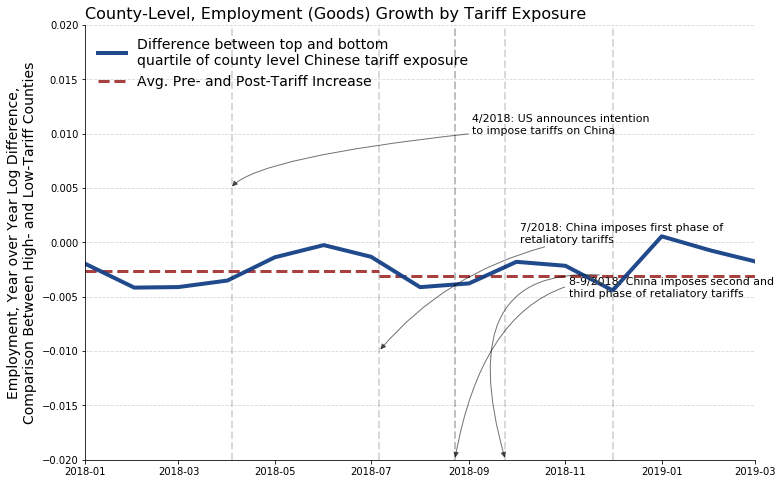

In [76]:
if driver_flag != True:
    
    fig, ax = plt.subplots(figsize = (12,8))

    mike_blue = tuple(np.array([20, 64, 134]) / 255)

    ax.plot((empl_most - empl_least), alpha = 0.95, color = mike_blue, linewidth = 4, 
        label = 'Difference between top and bottom\nquartile of county level Chinese tariff exposure')

#ax.plot(, alpha = 0.95, color = mike_blue , linewidth = 4, 
#        label = 'Bottom Quantile of Chinese Tariff Exposure Counties')

    ax.set_ylim(-0.02,0.02)

    ax.set_xlim(dt.datetime(2018,1,1),dt.datetime(2019,3,1))

    ax.spines["right"].set_visible(False)

    ax.spines["top"].set_visible(False)

    ax.yaxis.grid(alpha= 0.5, linestyle= "--")

    ax.set_ylabel("Employment, Year over Year Log Difference,\nComparison Between High- and Low-Tariff Counties", fontsize = 14)

    ax.hlines((empl_most - empl_least).loc[:"2018-07-01"].mean().iloc[0],
          dt.datetime(2018,1,1),dt.datetime(2018,7,6),
           linewidth = 3, color = 'darkred', alpha =0.75, linestyle = "--")

    ax.hlines((empl_most - empl_least).loc["2018-08-01":].mean().iloc[0],
          dt.datetime(2018,7,6),dt.datetime(2019,3,1),
           linewidth = 3, color = 'darkred', alpha =0.75, linestyle = "--", label = "Avg. Pre- and Post-Tariff Increase")

    ax.axvline(dt.datetime(2018,4,4), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

    ax.axvline(dt.datetime(2018,7,6), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

    ax.axvline(dt.datetime(2018,8,23), linewidth = 2, ls = "--", color = 'k', alpha =0.25)

    ax.axvline(dt.datetime(2018,9,24), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

    ax.axvline(dt.datetime(2018,12,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

    ax.legend(loc = 0, frameon  = False, fontsize = 14)

    ax.set_title("County-Level, Employment (Goods) Growth by Tariff Exposure", fontsize = 16, loc= "left" )

##############################################################################################

    ax.annotate(
    "4/2018: US announces intention\nto impose tariffs on China", 
    xy=(dt.datetime(2018,4,3), 0.005), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,9,3), 0.01), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
    )

##############################################################################################

    ax.annotate(
    "7/2018: China imposes first phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,7,6), -0.01), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,10,3), 0.0), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
    )

###################################################################################

    ax.annotate(
    "8-9/2018: China imposes second and \nthird phase of retaliatory tariffs", 
    xy=(dt.datetime(2018,8,23), -0.02), color='white',# This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,11,3), -0.005), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=80",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
    )

###################################################################################

    ax.annotate(
    "8-9/2018: China imposes second and \nthird phase of retaliatory tariffs", 
    xy=(dt.datetime(2018,9,24), -0.02), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,11,3), -0.005), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=286",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
    )

##############################################################################################

#plt.savefig(fig_path + "\\simple_employment_county_all.pdf", bbox_inches = "tight", dip = 3600)

#plt.show()

Then this will do the tabular representation using stuff before and after the first phase of the tradewar.

In [77]:
idx = pd.IndexSlice

me_mean = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.mean()

me_nobs = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.notnull().sum()

me_se = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.std()/me_nobs**0.5


le_mean = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.mean()

le_nobs = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.notnull().sum()

le_se = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.std()/me_nobs**0.5

if driver_flag != True:
    print(round(me_mean,4), round(me_se,3), me_nobs)
    print(round(le_mean,4), round(le_se,3), le_nobs)

-0.0073 0.001 4707
-0.0047 0.001 4491


In [78]:
idx = pd.IndexSlice

me_mean = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.mean()

me_nobs = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.notnull().sum()

me_se = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.std()/me_nobs**0.5


le_mean = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.mean()

le_nobs = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.notnull().sum()

le_se = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.std()/me_nobs**0.5

if driver_flag != True:
    print(round(me_mean,4), round(me_se,3), me_nobs)
    print(round(le_mean,4), round(le_se,3), le_nobs)

-0.0075 0.001 9369
-0.0045 0.001 8904


Not discussed in the paper, but what this looks like is that both looked relativly the same before the start of it interms of employment growth. But after the first phase, the least exposed did really well (this is consistent with a rocking US economy) but those most exposed did relativly poorly. But growth here is still positive. 

### Regression Analysis

This will walk through the results using employment data. The first set are the main (weighted results). The next set are the unweighted results. Numbers may not exactly match up to what is in the paper as some rounding is occuring. 

In [79]:
trade_county.columns

Index(['total_exp_pc', 'china_exp_pc', 'tariff', 'emplvl_2017', 'fips',
       'total_employment', 'emp_rtl', 'emp_all', 'emp_gds', 'emp_ngds',
       'rural_share', '2010_population', '2017_income', '2017_population',
       'log_tariff', 'log_exp_total', 'log_exp_china', 'log_employment',
       'const', 'state_fips', 'tariff_change', 'log_tariff_change',
       'employment_growth'],
      dtype='object')

### Weighted Results

#### Change on Change, no time or fixed effects

In [80]:
start = "2018-01-01"

weighting_var = '2010_population'

In [81]:
print("")
print("**********************************************************************************")
print("Raw Regression Employment Growth on Tariffs")
print("")

all_vars = ["const", "log_tariff_change", 'employment_growth',"2010_population",'total_employment']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-06-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset[weighting_var].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)


**********************************************************************************
Raw Regression Employment Growth on Tariffs

18
3252
                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0022
Estimator:                   PanelOLS   R-squared (Between):             -0.0026
No. Observations:               55053   R-squared (Within):               0.0069
Date:                Thu, Dec 26 2019   R-squared (Overall):              0.0022
Time:                        10:33:08   Log-likelihood                 1.066e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1292.3
Entities:                        3082   P-value                           0.0000
Avg Obs:                       17.863   Distribution:                 F(1,55051)
Min Obs:                       3.0000                

#### Change on Change, now with just the time effect.

In [82]:
print("")
print("**********************************************************************************")
print("Employment Growth on Tariff Change, Time fixed effcts")
print("")

all_vars = ["const", "log_tariff_change", 'employment_growth',"2010_population",'total_employment']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-06-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset[weighting_var].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights, time_effects = True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)


**********************************************************************************
Employment Growth on Tariff Change, Time fixed effcts

18
3252
                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):          -4.101e-05
No. Observations:               55053   R-squared (Within):              -0.0029
Date:                Thu, Dec 26 2019   R-squared (Overall):             -0.0015
Time:                        10:33:08   Log-likelihood                 1.071e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1195.3
Entities:                        3082   P-value                           0.0000
Avg Obs:                       17.863   Distribution:                 F(1,55034)
Min Obs:                       3.0000      

#### Change on Change, time effects and county-level fixed effects

In [83]:
print("")
print("**********************************************************************************")
print("Employment Growth on Tariff Change, Time and County-level fixed effcts")
print("")

all_vars = ["const", "log_tariff_change", 'employment_growth',"2010_population",'total_employment']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-06-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset[weighting_var].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights, entity_effects=True, 
               time_effects = True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)


**********************************************************************************
Employment Growth on Tariff Change, Time and County-level fixed effcts

18
3252
                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):             -0.0005
No. Observations:               55053   R-squared (Within):              -0.0065
Date:                Thu, Dec 26 2019   R-squared (Overall):             -0.0035
Time:                        10:33:09   Log-likelihood                 1.263e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2093.5
Entities:                        3082   P-value                           0.0000
Avg Obs:                       17.863   Distribution:                 F(1,51953)
Min Obs:                  

Now controll for time-varying shocks that may be correlated with the tariff. So I will interact a county's goods producing share and rural share with time dummies. Which is what I do below.

In [84]:
trade_county["man_share"] = trade_county["emp_gds"] / trade_county["emp_all"]

trade_county["man_share"] = trade_county["man_share"].replace(np.inf, np.nan)

trans = lambda df: df.iloc[0:11].mean()

#trade_county.groupby(["GEOFIPS"]).log_tariff.transform(trans)

trade_county["avg_man_share"] = trade_county.groupby(["GEOFIPS"]).man_share.transform(trans)

trade_county["avg_man_share"].mean()

0.27251695676746807

In [85]:
years = [18,19]

quarters = [[1,2],[3,4],[5,6],[7,8],[9,10],[11,12]]

#quarters = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12]]

rural_list = []

man_list = []

tariff_list = []

count = 0

event_study = pd.DataFrame([])

for xxx in years:
    
    for yyy in quarters:
        
        if (xxx == 19) & (yyy[0] > 6):
            break
            
        
        year = "20" + str(xxx)
        year = int(year)
        
        date_cond = ((trade_county.index.get_level_values(1).month.isin(yyy)) 
             & (trade_county.index.get_level_values(1).year == year ))
        
        name = "M" + str(yyy) + "_" + str(xxx)
        
        #print(name)
        
        if count == 0:
            
            event_study = pd.merge(trade_county.reset_index(),
                                   pd.get_dummies(date_cond)[1].rename(name),
                                   left_index = True, right_index= True)
        else:
            
            event_study = pd.merge(event_study, 
                       pd.get_dummies(date_cond)[1].rename(name),
                                   left_index = True, right_index= True)
               
        name_t = name + "_t"
        
        name_r = name + "_r"
        
        name_m = name + "_m"
        
        
        # This will be the dummy variable on the leads

        event_study[name_r] = event_study.rural_share.multiply(event_study[name], axis = 0)
         # This will be the dummy variable on ineraction with rural share

        event_study[name_m] = event_study.avg_man_share.multiply(event_study[name], axis = 0) 
        # This will be the dummy variable on ineraction with goods employment share
        
        count = count + 1
        
        tariff_list.append(name_t)
        
        man_list.append(name_m)
        
        rural_list.append(name_r)
        
        #print(count)
        
######################################################## 
        
event_study.set_index(["GEOFIPS", "time"],inplace = True)

Now run the regression with these interaction terms. 

In [86]:
print("")
print("**********************************************************************************")
print("Employment Growth on Tariff Change, Interaction Specification")
print("")

all_vars = ["const", "log_tariff_change", 'employment_growth',"2010_population",'total_employment',
           "rural_share", "man_share"]

all_vars.extend(man_list)

all_vars.extend(rural_list)

dataset = event_study[all_vars].loc[idx[:,"2018-01-01":"2019-6-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset["2010_population"].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

exog_vars.extend(man_list)

exog_vars.extend(rural_list)

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars],weights = weights,  time_effects = True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)


**********************************************************************************
Employment Growth on Tariff Change, Interaction Specification

18
3252
                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0048
Estimator:                   PanelOLS   R-squared (Between):              0.0052
No. Observations:               54927   R-squared (Within):              -0.0274
Date:                Thu, Dec 26 2019   R-squared (Overall):             -0.0113
Time:                        10:33:11   Log-likelihood                  1.07e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      76.828
Entities:                        3075   P-value                           0.0000
Avg Obs:                       17.862   Distribution:                F(19,54890)
Min Obs:                       3.00

In [87]:
fe_res.params.log_tariff_change

-0.1975151887059971

**Aggregate Effects** This provides a simple calcuation for the aggregate outcomes. The consumption number only makes sense with retail employment as it exploits a unitary elasticity of retail employment to PCE.

In [88]:
def missing_jobs(df):
    
    foo_df = pd.DataFrame([])
    
    foo_df["g_cft"] = df.employment_growth - (fe_res.params.log_tariff_change)*df.log_tariff_change
    # compute the counterfactual change in growth...

    foo_df["f_log_value"] = df.log_employment - df.employment_growth
    # this is just so we can line stuff up, e.g. in 2018-12 it will line up
    # the 2017-12 value (seen in the data)

    foo_df["log_value_cft"] = foo_df.f_log_value + foo_df.g_cft
    # This is the counterfactual car value. Take the counterfactual growth rate
    # then add it to the previous years log_vale (hence the f_log_value)

    foo_df["missing_jobs"] = np.exp(foo_df.log_value_cft) - np.exp(df.log_employment)
    # The missing cars take the exp of log value and differences it.
    
    idx = pd.IndexSlice
    
    # Jobs are a stock, not a flow. So for each period we come up
    # with difference in jobs, then to figure out the change in the flow, I will difference,
    # and then sum across stuff.

    return foo_df.loc[idx[:,"2018-01-01":"2019-07-01"],:].missing_jobs.diff(1).sum()
    # 

In [89]:
grp = trade_county[["log_employment", "employment_growth", "log_tariff_change"]].groupby(["GEOFIPS"])

ms_jobs = grp.apply(missing_jobs)

emp_cnty = trade_county["total_employment"].groupby(["GEOFIPS"]).mean()

In [90]:
test = pd.concat([ms_jobs, emp_cnty], axis = 1)

In [91]:
test.columns = ["missing_jobs", "2017_emp"]

In [92]:
test["frac_lost"] = test.missing_jobs / test["2017_emp"]

In [93]:
test.sort_values(by = ["frac_lost"], ascending = False).iloc[0:1000].mean()

missing_jobs       4.956731
2017_emp        5510.494000
frac_lost          0.001737
dtype: float64

In [94]:
ms_jobs

GEOFIPS
1001     -0.177440
1003     18.840637
1005      3.613286
1007      1.907242
1009      1.369746
           ...    
72113     9.013385
72115     0.962300
72117     0.194139
72119     2.072020
72121     7.092882
Length: 3252, dtype: float64

In [95]:
ms_jobs = ms_jobs.to_frame(name = "lost_jobs")

In [96]:
print("")
print("**********************************************************************************")
print("Aggregate Effects")
print("")
print("Total Lost Jobs", round(ms_jobs.sum()[0],1))
# This should be something like 25000 retail jobs lost


**********************************************************************************
Aggregate Effects

Total Lost Jobs 22498.6


In [101]:
ms_jobs.head(20)

,lost_jobs
GEOFIPS,
1001,-0.177440
1003,18.840637
1005,3.613286
1007,1.907242
1009,1.369746
1011,0.476707
1013,0.707260
1015,8.594741
1017,-0.028080


In [ ]:
ms_jobs.to_csv(file_path + "\\data\\lost_jobs.csv")

In [127]:
PCE = 14000000000000

total_cost = PCE*(ms_jobs.sum()/ 
                (np.exp(trade_county["log_employment"].xs('2017-06-1', level=1)).sum()))

clost = total_cost


if emp_measure == "emp_rtl":

    print("Total Consumption Loss, Billions", round(clost/1000000000,1)[0])

Total Consumption, Billions 19.8


In [124]:
# PCE is about 14,000 billion. (14 trillion)
# Then we will mulitpliy by the percent of retail jobs lost 
# the same as percent of PCE lost (under a one for one assumption)
# this tells us the lost consumption for that group. Then divide through
# and we get reduction in consumption per group

PCE = 14000000000000

group = most_exposed

total_cost = PCE*(ms_jobs.loc[group].sum()/ 
                (np.exp(trade_county["log_employment"].xs('2017-06-1', level=1)).sum()))

clost_most = total_cost / trade_county["total_employment"].loc[group].xs('2017-06-1', level=1).sum()

group = least_exposed

total_cost = PCE*(ms_jobs.loc[group].sum()/ 
                (np.exp(trade_county["log_employment"].xs('2017-06-1', level=1)).sum()))

clost_least = total_cost / trade_county["total_employment"].loc[group].xs('2017-06-1', level=1).sum()

In [125]:
if emp_measure == "emp_rtl":

    print("Consumption Loss Per Worker, Most Exposed:", round(clost_most,3))
    print("Consumption Loss Per Worker, Least Exposed:", round(clost_least,3))

Consumption Loss Per Worker, Most Exposed: lost_jobs    629.515
dtype: float64
Consumption Loss Per Worker, Least Exposed: lost_jobs    46.849
dtype: float64


### Unweigted resuts

#### Change on Change, no fixed effects or time effects

In [34]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-06-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars])

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

if driver_flag != True:

    print(fe_res)

#df = pd.concat([dataset.employment_growth, fe_res.fitted_values],1).dropna()
#print(df.corr().iloc[0,1] ** 2)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                     2.116e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0002
No. Observations:               57858   R-squared (Within):            1.549e-05
Date:                Thu, Dec 05 2019   R-squared (Overall):           2.116e-06
Time:                        12:18:23   Log-likelihood                 7.898e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.1224
Entities:                        3225   P-value                           0.7264
Avg Obs:                       17.940   Distribution:                 F(1,57856)
Min Obs:                       3.0000                                           
Max Obs:                       18.000   F-statistic (robust):             0.0081
                            

#### Change on Change, time effects

In [35]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-06-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], time_effects = True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

if driver_flag != True:

    print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                     1.736e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0001
No. Observations:               57858   R-squared (Within):           -1.991e-05
Date:                Thu, Dec 05 2019   R-squared (Overall):          -6.312e-06
Time:                        12:19:00   Log-likelihood                 7.901e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.1004
Entities:                        3225   P-value                           0.7513
Avg Obs:                       17.940   Distribution:                 F(1,57839)
Min Obs:                       3.0000                                           
Max Obs:                       18.000   F-statistic (robust):             0.0057
                            

#### Change on Change, time and county-level fixed effects

In [36]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-06-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], entity_effects=True, time_effects = True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

if driver_flag != True:

    print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                     7.483e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0002
No. Observations:               57858   R-squared (Within):             2.88e-05
Date:                Thu, Dec 05 2019   R-squared (Overall):           -1.39e-06
Time:                        12:19:01   Log-likelihood                 1.027e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.4087
Entities:                        3225   P-value                           0.5227
Avg Obs:                       17.940   Distribution:                 F(1,54615)
Min Obs:                       3.0000                                           
Max Obs:                       18.000   F-statistic (robust):             0.0229
                            

This is the most interesting one. Here things go to zero and there is no effect. What I think the weighting is really doing is variance reduction rather than some issue about means. So there are a bunch of small county's with employment patterns all over the place. By weighting on county size, this reduces the impact those guys have and, hence, you get the different result. 

In [37]:
0.21*(3.79-0.15)

0.7644